# Table of contents
1. [Introduction](#introduction)
1. [Import data](#paragraph1)
    1. [Data Dict](#subparagraph1)
    1. [Data Summary](#subparagraph2)
1. [Categorical Features](#paragraph2)
1. [Continuous Features](#paragraph3)
1. [Examining the Target](#paragraph4)
1. [Spatial Analysis](#paragraph5)
1. [Temporal Analysis](#paragraph6)
1. [Preliminary Model_Fitting](#paragraph7)



In [4]:
#pydata
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# display and visualization
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML, Markdown
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

# custom tools
import sys
sys.path.insert(1, '../scripts/')
# import eda_tools as et
import data_munging_tools as dmt
import model_fitting_tools as mft
import munge_williston_data as mwd

In [5]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

## Introduction <a name="introduction"></a>
### Exploring Data

I usually approach EDA in the following way:
1. Create a data dict which we can annotate as we go.
1. For each feature, compute summary statistics for following categories:
    1. Data Type
    1. Missingness
    1. Cardinality (number of unique values)
    1. Central Tendency
    1. Dispersion
    1. Correlation with target
1. Categorical Variables:
    1. Value Counts and Box Plots with the Target
1. Continuous Variables:
    1. Univariate plots (I like stripplots)
    1. Bivariate plots (I like scattermatrices with groups of variables)
    1. Correlation among continuous features (correlation matrix clustermap)
1. Geographic Analysis (if applicable)
    1. Maps, colored by categorical and continuous features
1. Temporal Analysis (if applicable)
    1. Line plots where `time` is on the x-axis



### Load data

In [6]:
# `pd.read_html()`  requires packages: lxml, html5lib, beautifulsoup4
data_dict = (pd.read_html('../data/AttributeDescriptions.html')[0]
             .copy()
             .rename(columns=lambda x: x.lower().replace(" ", "_"))
             .assign(field_name=lambda x: x["field_name"].apply(lambda x: x.lower()))
             .set_index("field_name")
             .sort_index()
            )

In [7]:
display(Markdown("### Data Dict"))
data_dict.head().style.set_properties(subset=['description'], **{'width': '700px'})

### Data Dict

In [8]:
# Load the dataframes
test_df = pd.read_csv('../data/cleaned-input.test.tsv', sep='\t', low_memory=False)
train_df = pd.read_csv('../data/cleaned-input.training.tsv', sep='\t', low_memory=False)

concat_df = pd.concat([test_df.assign(data_group="TEST"),
                       train_df.assign(data_group="TRAIN")
                      ])

# Specify some columns for future reference
coord_cols = ["surface_lat", "surface_lng", "bh_lat", "bh_lng"]
target_col = "production_liquid_180"

## Create a dataframe for further inspection
There's actually quite a bit going on here.
I'm doing some basic data munging and feature engineering before even looking at the data.
Two main things are happening:
1. I want a per-foot calculation for many of the completion features, because that gives a true notion of "stimulation intensity"
    1. In order to do so, we need some notion of the lateral length of each well. My function needs a little bit of work, because it seems to be generating null values in many cases.
    1. Looking at it in per-foot terms also helps us spot outliers and uncover patterns
1. Another thing we can calculate relatively easily is interwell spacing.
    1. I do this by first calculating a midpoint for each well and then calculating pairwise distances between each midpoint and picking the shortest for each well.


In [9]:
inspect_df = (concat_df.copy()
                      .rename(columns=str.lower)
                      .assign(api = lambda x: x["api"].str.strip("US"))
                      .set_index("api")
                      .sort_index(axis=1)
                      .assign(length=lambda x: mwd.haversine_distance(x["surface_lat"], 
                                                                      x["surface_lng"], 
                                                                      x["bh_lat"], 
                                                                      x["bh_lng"]),
                              prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                              fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                              stage_spacing=lambda x: x["total_num_stages"] / x["length"],
                              range_tvd=lambda x: x["max_tvd"] - x["min_tvd"],
                              frac_year=lambda x: x["spud_date"].apply(lambda x: float(str(x).split("-")[0]))
                             )
                      .pipe(mwd.find_distance_to_nearest_neighbor, *coord_cols)
             )

In [10]:
# I almost always look at the head and tail of the data first.
display(inspect_df.head(1),
        inspect_df.tail(1)
       )

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33023010680000              90.00   48.73 -103.85      28/64     DIVIDE   

                 currentoperator                 currentwellname data_group  \
api                                                                           
33023010680000  HUNT OIL COMPANY  WRITING ROCK  161-101-30-31H-1       TEST   

                dfelev     fieldname  ...    wellbore wellstatus  welltype  \
api                                   ...                                    
33023010680000     nan  WRITING ROCK  ...  HORIZONTAL          A        OG   

                length prop_per_ft fluid_per_ft  stage_spacing  range_tvd  \
api                                                                         
33023010680000 6164.12      438.36         9.44           0.00     587.62   

                frac_year  shortest_dist  
api                                       
33023010680000    2013.00          29.39  

[1 rows x 60 columns]

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33007016960000              40.00   47.30 -103.08      26/64   BILLINGS   

                   currentoperator             currentwellname data_group  \
api                                                                         
33007016960000  PETRO-HUNT, L.L.C.  ZABOLOTNY  144-98-3A-10-1H      TRAIN   

                dfelev     fieldname  ...    wellbore wellstatus  welltype  \
api                                   ...                                    
33007016960000     nan  LITTLE KNIFE  ...  HORIZONTAL          A        OG   

                 length prop_per_ft fluid_per_ft  stage_spacing  range_tvd  \
api                                                                          
33007016960000 10357.79      268.25         5.98           0.00     537.21   

                frac_year  shortest_dist  
api                                       
33007016960000    2012.00          31.49  

[1 rows x 60 columns]

In [11]:
inspect_df.loc["33023010680000", ["bh_lat", "shortest_dist"]]

bh_lat          48.73
shortest_dist   29.39
Name: 33023010680000, dtype: object

In [12]:
inspect_df["spud_date"].isnull().sum()

36

In [13]:
inspect_df.query("prop_per_ft == prop_per_ft & total_lbs_proppant != total_lbs_proppant")

Empty DataFrame
Columns: [bakken_isopach_ft, bh_lat, bh_lng, choke_size, countyname, currentoperator, currentwellname, data_group, dfelev, fieldname, fileno, footages, grelev, kbelev, leasename, leasenumber, legs, max_tvd, mean_tvd, min_tvd, num_pools_produced, originaloperator, originalwellname, producedpools, production_liquid_120, production_liquid_150, production_liquid_180, production_liquid_1825, production_liquid_270, production_liquid_30, production_liquid_365, production_liquid_60, production_liquid_730, production_liquid_90, qq, range, section, spud_date, std_tvd, stimulated_formation, surface_lat, surface_lng, td, total_lbs_proppant, total_num_stages, total_volume_bbls, township, tvd, type_treatment, well_status_date, wellbore, wellstatus, welltype, length, prop_per_ft, fluid_per_ft, stage_spacing, range_tvd, frac_year, shortest_dist]
Index: []

[0 rows x 60 columns]

In [14]:
inspect_df.loc["33023010680000", ["bh_lat", "spud_date"]]

bh_lat            48.73
spud_date    2013-12-03
Name: 33023010680000, dtype: object

In [15]:
df_summary = dmt.make_df_summary(inspect_df, target_col=target_col)
# display(df_summary.head())

In [16]:
summary_df = df_summary.join(data_dict)
summary_df["using"] = np.nan
summary_df["notes"] = np.nan
# display(summary_df.head())

In [17]:
print("Feature categories already in the data dict:")
summary_df.category.value_counts(dropna=False)

Feature categories already in the data dict:


NaN                 31
Location            11
Target              10
CompletionDesign     4
Geology              3
Identifier           1
Name: category, dtype: int64

In [18]:
# Filling out the rest of the summary df

# The thing we are trying to predict
summary_df.loc[summary_df.category == 'Target', ["using"]] = False

# Location
summary_df.loc[["footages", "qq"], "category"] = "Location"
summary_df.loc[summary_df.category == 'Location', ["using"]] = False

# Depth measurements
tvd_cols = summary_df.T.filter(regex="tvd").columns.tolist()
tvd_cols.append("td")
summary_df.loc[tvd_cols, ["category", "using"]] = "Location", True
summary_df.loc["max_tvd", "using"] = False
summary_df.loc["max_tvd", "notes"] = "basically the same as `tvd`"

# Elevation measurements
elev_cols = summary_df.T.filter(regex="elev").columns.tolist()
summary_df.loc[elev_cols, ["category", "using"]] = "Location", False

# Geology
summary_df.loc['bakken_isopach_ft', "using"] = True
summary_df.loc[['producedpools', 'stimulated_formation'], "using"] = False

### Completion Design Parameters
summary_df.loc[summary_df.category == 'CompletionDesign', "notes"] = "total completion"
summary_df.loc[["length", "legs", "choke_size", "num_pools_produced"], "category"] = "CompletionDesign"
summary_df.loc[summary_df.category == 'CompletionDesign', "using"] = True
summary_df.loc[["type_treatment", "legs", "num_pools_produced"], ["using", "notes"]] = False , "no meaningful variation"
normd_cols = ["prop_per_ft", "fluid_per_ft", "shortest_dist", "stage_spacing"]
summary_df.loc[normd_cols + ["legs", "length"], "category"] = "CompletionDesign"
summary_df.loc[normd_cols, ["using", "notes"]] = True, "normd completion"
summary_df.loc["choke_size", "notes"] = "needs parsing"

# Metadata
meta_cols = ["fileno", 
             "data_group",
             "currentoperator", 
             "currentwellname", 
             "originaloperator", 
             "originalwellname", 
             "spud_date", 
             "well_status_date", 
             "wellbore", 
             "wellstatus", 
             "welltype"]

summary_df.loc[meta_cols, "category"] = "metadata"
summary_df.loc[meta_cols, "using"] = False

In [19]:
summary_df.query("using == False").index.tolist()

['fileno',
 'num_pools_produced',
 'section',
 'bh_lat',
 'bh_lng',
 'dfelev',
 'grelev',
 'kbelev',
 'legs',
 'max_tvd',
 'production_liquid_120',
 'production_liquid_150',
 'production_liquid_180',
 'production_liquid_1825',
 'production_liquid_270',
 'production_liquid_30',
 'production_liquid_365',
 'production_liquid_60',
 'production_liquid_730',
 'production_liquid_90',
 'surface_lat',
 'surface_lng',
 'countyname',
 'currentoperator',
 'currentwellname',
 'data_group',
 'fieldname',
 'footages',
 'leasename',
 'leasenumber',
 'originaloperator',
 'originalwellname',
 'producedpools',
 'qq',
 'range',
 'spud_date',
 'stimulated_formation',
 'township',
 'type_treatment',
 'well_status_date',
 'wellbore',
 'wellstatus',
 'welltype']

 <a name="paragraph2"></a>
# Inspect Categorical Features

In [20]:
cat_df = inspect_df.copy().select_dtypes("O")

In [21]:
for col in cat_df.columns:
    nunique = cat_df[col].nunique()
    display(Markdown(f"### {col}: {nunique}"))
    display(cat_df[col].value_counts().to_frame().reset_index().head(5))

### choke_size: 234

index  choke_size
0  48/64         659
1  24/64         643
2  32/64         596
3  28/64         428
4    /64         412

### countyname: 15

index  countyname
0   MCKENZIE        2229
1  MOUNTRAIL        1997
2       DUNN        1343
3   WILLIAMS        1336
4     DIVIDE         540

### currentoperator: 57

index  currentoperator
0  WHITING OIL AND GAS CORPORATION             1079
1      CONTINENTAL RESOURCES, INC.              926
2  HESS BAKKEN INVESTMENTS II, LLC              814
3              EOG RESOURCES, INC.              515
4                  XTO ENERGY INC.              514

### currentwellname: 8114

index  currentwellname
0             PENNINGTON  41-4H                2
1  P WOOD  154-98-3-27-34-15H3M                1
2          INGA  150-99-11-2-3H                1
3                 NELSON  5-18H                1
4  BB-BELQUIST-  150-95-1110H-4                1

### data_group: 2

index  data_group
0  TRAIN        6529
1   TEST        1586

### fieldname: 342

index  fieldname
0        SANISH        485
1      PARSHALL        328
2         ALGER        251
3  MURPHY CREEK        168
4     SIVERSTON        158

### footages: 7537

index  footages
0  250 FNL  1320 FWL        14
1  300 FNL  1320 FEL        13
2  300 FSL  1320 FEL        13
3   500 FNL  500 FWL        10
4   300 FNL  300 FWL         9

### leasename: 3712

index  leasename
0  FORT BERTHOLD        113
1            MHA         86
2       WAYZETTA         58
3         AUSTIN         47
4       PARSHALL         43

### leasenumber: 5421

index  leasenumber
0    1-H           84
1      1           31
2  1-22H           24
3  1-29H           23
4    #1H           21

### originaloperator: 102

index  originaloperator
0      CONTINENTAL RESOURCES, INC.               889
1  WHITING OIL AND GAS CORPORATION               746
2                 HESS CORPORATION               676
3              EOG RESOURCES, INC.               516
4             MARATHON OIL COMPANY               441

### originalwellname: 8108

index  originalwellname
0                         HANSEN  21-3H                 2
1                           ANGUS  2-9H                 2
2                  CCU POWELL  31-29MBH                 2
3  STATE OF NORTH DAKOTA  154-99-16A-5H                 2
4                     PENNINGTON  41-4H                 2

### producedpools: 15

index  producedpools
0              BAKKEN           7845
1              SANISH            102
2           SPEARFISH             88
3  BAKKEN/THREE FORKS             37
4             MADISON             10

### qq: 47

index    qq
0  SWSE  1136
1  SESE   927
2  SESW   926
3  NENW   791
4  NWNW   747

### range: 25

index  range
0  95 W    935
1  92 W    811
2  96 W    733
3  99 W    710
4  93 W    703

### spud_date: 2258

index  spud_date
0  2012-10-01         14
1  2013-05-02         14
2  2013-01-15         14
3  2013-06-18         13
4  2014-01-11         12

### stimulated_formation: 15

index  stimulated_formation
0       bakken                  4951
1  three forks                  2016
2    spearfish                   104
3    pronghorn                    10
4      madison                     5

### township: 30

index  township
0  152 N       824
1  153 N       728
2  154 N       682
3  155 N       652
4  151 N       652

### type_treatment: 9

index  type_treatment
0           sand frac            5729
1               other             797
2            fracture             184
3  fracture,sand frac               3
4     other,sand frac               3

### well_status_date: 2286

index  well_status_date
0  2013-04-18                15
1  2012-12-14                15
2  2013-10-17                14
3  2014-07-29                14
4  2012-06-26                14

### wellbore: 3

index  wellbore
0           HORIZONTAL      8104
1  HORIZONTAL RE-ENTRY         6
2          DIRECTIONAL         5

### wellstatus: 8

index  wellstatus
0     A        7773
1    IA         305
2    TA          10
3    PA           8
4    AB           7

### welltype: 1

index  welltype
0    OG      8115

## Categorical Plots

In [22]:
cat_df = (inspect_df.copy()
                  .select_dtypes("O")
                  .pipe(dmt.reduce_cardinality)
         )

cat_cols = cat_df.columns

cat_df = cat_df.join(inspect_df.filter([target_col]))

In [23]:
print("categorical features:")
cat_cols

categorical features:


Index(['choke_size', 'countyname', 'currentoperator', 'currentwellname',
       'data_group', 'fieldname', 'footages', 'leasename', 'leasenumber',
       'originaloperator', 'originalwellname', 'producedpools', 'qq', 'range',
       'spud_date', 'stimulated_formation', 'township', 'type_treatment',
       'well_status_date', 'wellbore', 'wellstatus', 'welltype'],
      dtype='object')

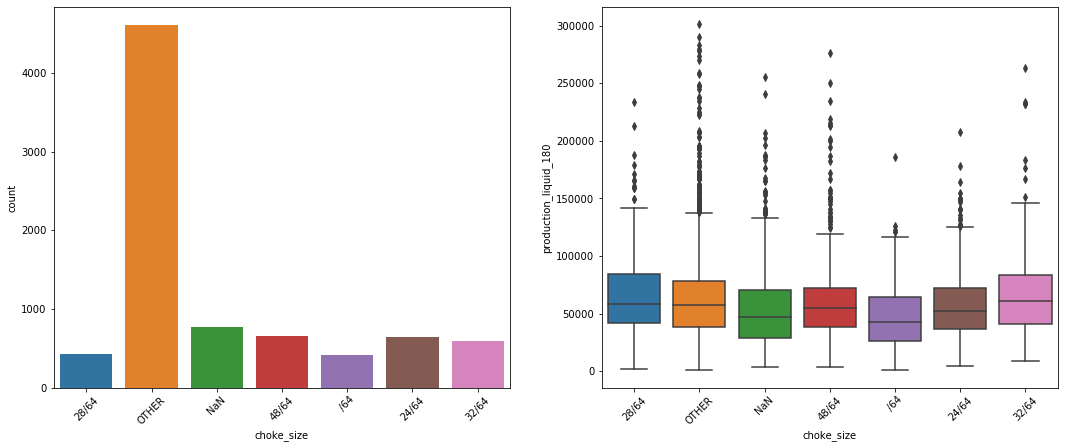

In [24]:
dmt.inspect_cat_plots(cat_df, "choke_size", target_col)

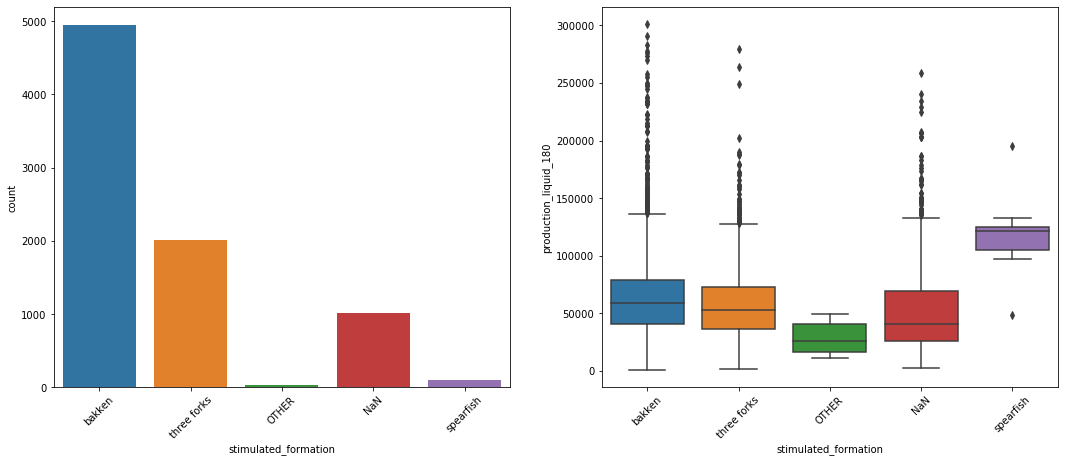

In [25]:
dmt.inspect_cat_plots(cat_df, "stimulated_formation", target_col)

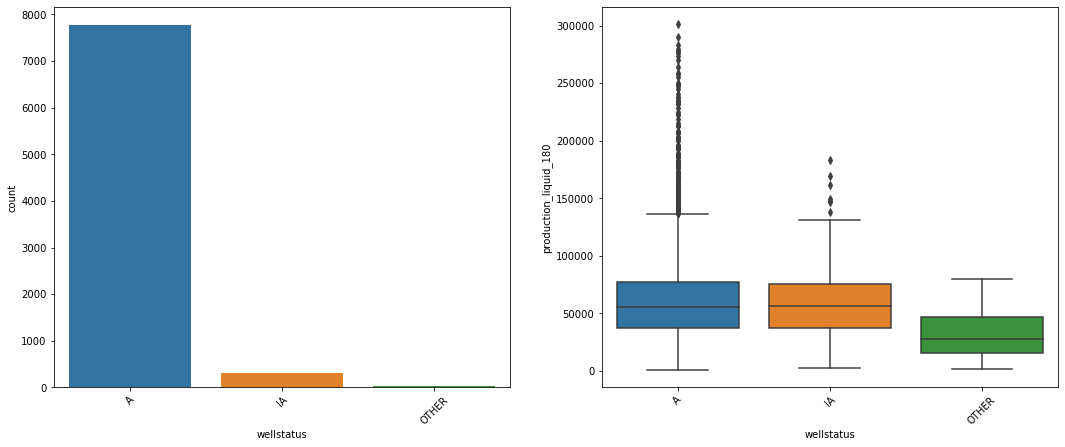

In [26]:
dmt.inspect_cat_plots(cat_df, "wellstatus", target_col)

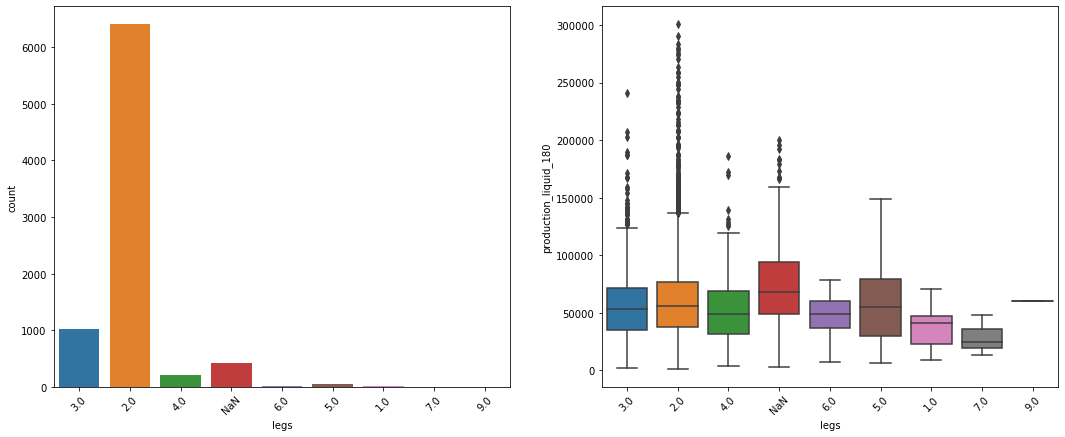

In [27]:
dmt.inspect_cat_plots(inspect_df, "legs", target_col)

### Conclusion: theres nothing really useful here, except maybe choke size, legs, and stimulated formation

# Inspect Continuous Features  <a name="paragraph3"></a>

In [28]:
foi = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
'legs',
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing', 
'mean_tvd',
'bakken_isopach_ft',
'choke_size',
'shortest_dist',
target_col
])

total_cols = sorted([
'total_lbs_proppant',
'total_num_stages', 
'total_volume_bbls',
'length',
target_col
])

normd_cols = sorted([
'prop_per_ft',
'fluid_per_ft', 
'stage_spacing',
target_col
])

other = sorted([
'mean_tvd',
'bakken_isopach_ft' 
])

In [29]:
cont_df = (inspect_df.copy()
                   .assign(choke_size=lambda x: x["choke_size"].apply(lambda x: mwd.parse_choke_size(x)))
                   .select_dtypes("number")
                   .filter(foi)
                   .sort_index(axis=1)
          )

In [30]:
cont_df.shape

(8115, 13)

In [31]:
cont_df.columns

Index(['bakken_isopach_ft', 'choke_size', 'fluid_per_ft', 'legs', 'length',
       'mean_tvd', 'production_liquid_180', 'prop_per_ft', 'shortest_dist',
       'stage_spacing', 'total_lbs_proppant', 'total_num_stages',
       'total_volume_bbls'],
      dtype='object')

## Setting extreme outliers to NaN

In [32]:
thresh_dict = defaultdict(lambda: {"min": 0, "max": float("inf")})
thresh_dict["total_lbs_proppant"]["max"] = 20000000.0
thresh_dict["total_volume_bbls"]["max"] = 500000.0
thresh_dict["length"]["min"] = 2000
thresh_dict["mean_tvd"]["min"] = 4000
thresh_dict["total_num_stages"]["min"] = 5

In [33]:
cont_df.head()

bakken_isopach_ft  choke_size  fluid_per_ft  legs   length  \
api                                                                          
33023010680000              90.00        0.44          9.44  3.00  6164.12   
33061019000000             110.00        1.00          2.97  2.00  9150.57   
33053051430000              80.00        0.28          1.62  2.00  9926.80   
33053045070000              80.00        0.34          4.69  2.00 10054.43   
33053047660000              90.00        0.61         34.53  3.00  2785.10   

                mean_tvd  production_liquid_180  prop_per_ft  shortest_dist  \
api                                                                           
33023010680000   8682.48               25694.00       438.36          29.39   
33061019000000   9827.68               45299.00       204.01           3.97   
33053051430000  10980.10               12653.00       166.36           1.64   
33053045070000  11024.49               79246.00       648.03           7.88   
33053047660000  11109.07               74794.00      1526.69           9.87   

                stage_spacing  total_lbs_proppant  total_num_stages  \
api                                                                   
33023010680000           0.00          2702100.00                25   
33061019000000           0.00          1866840.00                26   
33053051430000           0.00          1651440.00                32   
33053045070000           0.00          6515590.00                23   
33053047660000           0.01          4251992.00                33   

                total_volume_bbls  
api                                
33023010680000           58176.00  
33061019000000           27187.00  
33053051430000           16129.00  
33053045070000           47161.00  
33053047660000           96171.00

In [34]:
cont_df.shape

(8115, 13)

In [35]:
num_missing = inspect_df[foi + coord_cols].isnull().sum(axis=1).sort_values(ascending=False)

In [36]:
num_missing.head()

api
33089005680000    13
33053060140000    13
33053059140000    12
33053059160000    12
33061029950000    11
dtype: int64

{'min': 0, 'max': 500000.0}
1207


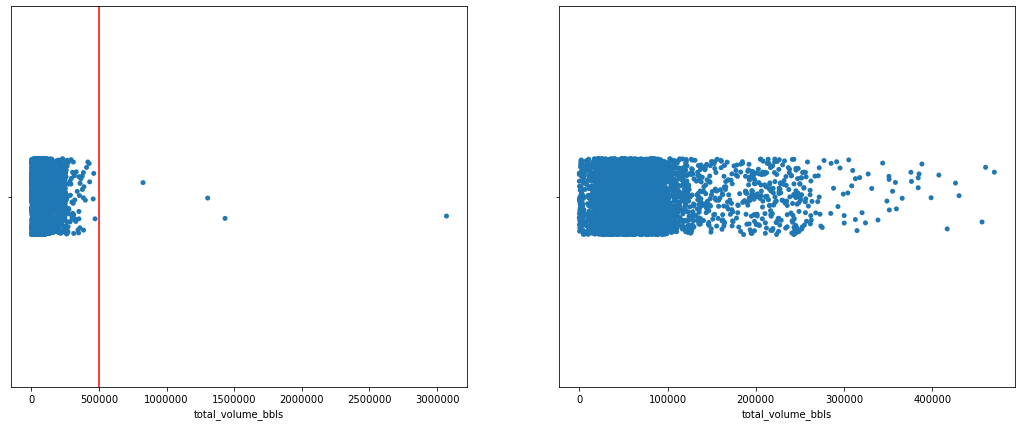

In [37]:
dmt.make_strip_plots(cont_df, "total_volume_bbls", thresh_dict)

{'min': 4000, 'max': inf}
501


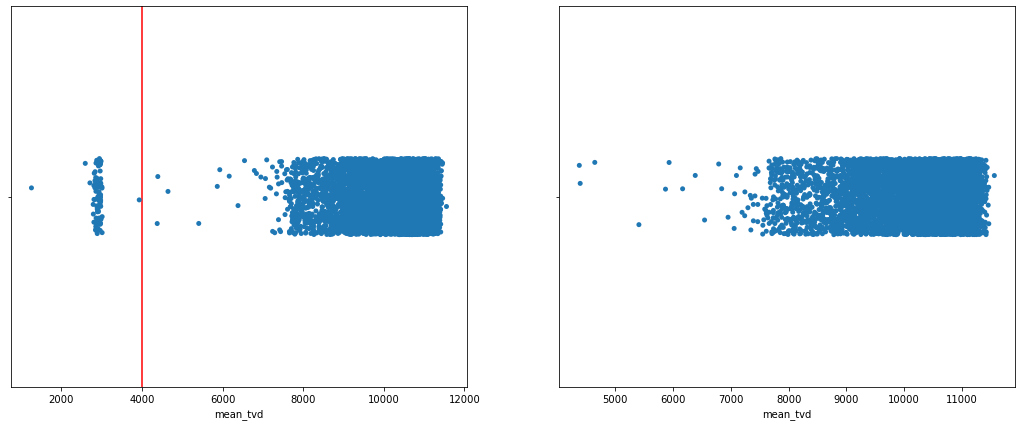

In [38]:
dmt.make_strip_plots(cont_df, "mean_tvd", thresh_dict)

{'min': 5, 'max': inf}
747


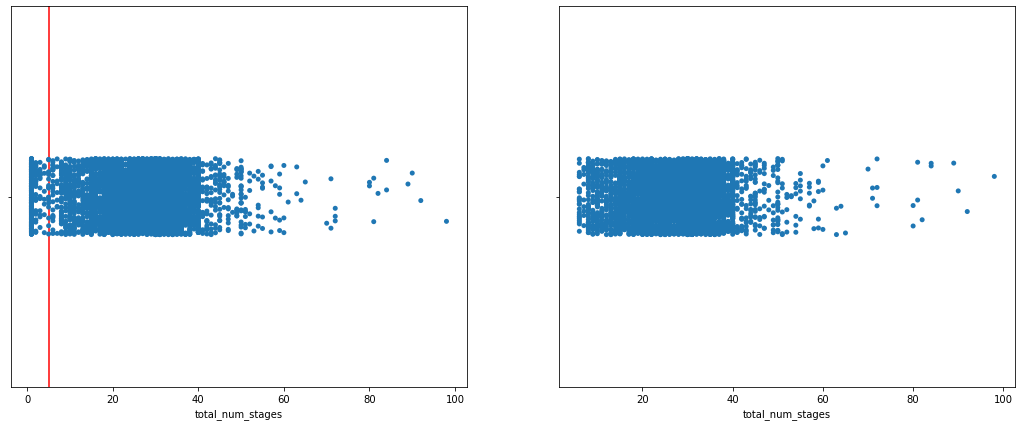

In [39]:
dmt.make_strip_plots(cont_df, "total_num_stages", thresh_dict)

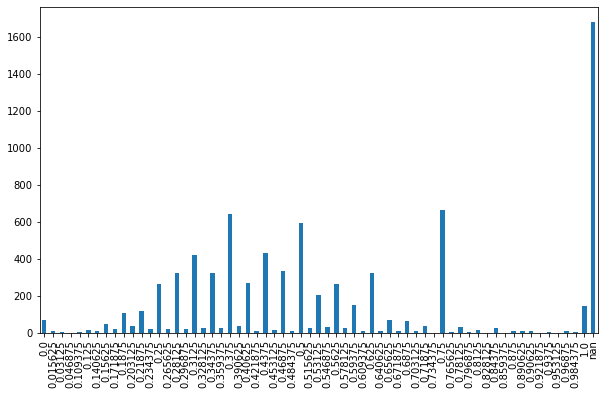

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))
cont_df.choke_size.value_counts(dropna=False).sort_index().plot.bar()

### Examining Target

In [41]:
display(Markdown("### 224 wells in the training set are missing target values at IP 180"))
inspect_df.query(f"{target_col} != {target_col}").shape

### 224 wells in the training set are missing target values at IP 180

(278, 60)

In [42]:
display(Markdown("### 54 wells in the test set are missing target values at IP 180"))
test_df.query(f"{target_col} != {target_col}").shape

### 54 wells in the test set are missing target values at IP 180

(54, 53)

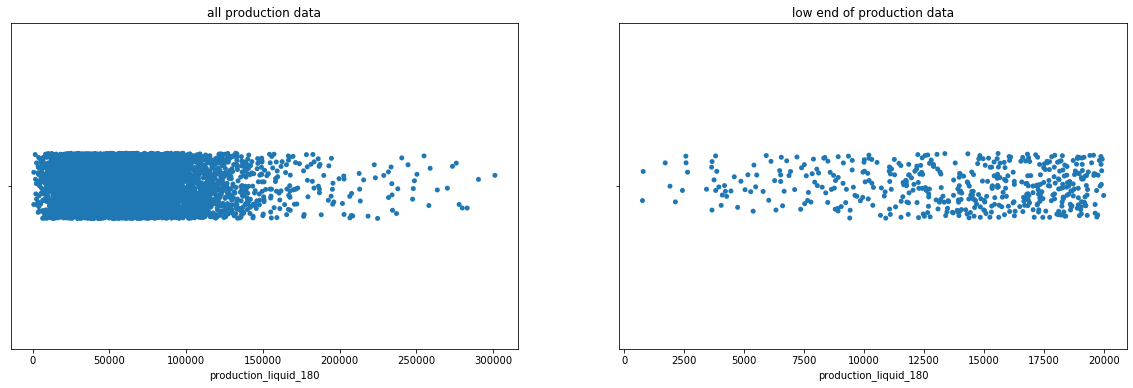

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.stripplot(inspect_df[target_col], ax=ax[0])
sns.stripplot(inspect_df.query(f"{target_col} < 20000")[target_col], ax=ax[1])
ax[0].set_title("all production data")
ax[1].set_title("low end of production data")
plt.show()

In [44]:
clean_df = (inspect_df.copy()
                    .assign(choke_size= lambda x: x["choke_size"].apply(mwd.parse_choke_size))
                    .pipe(dmt.remove_outiers, thresh_dict)
                    .assign(prop_per_ft=lambda x: x["total_lbs_proppant"] / x["length"],
                            fluid_per_ft=lambda x: x["total_volume_bbls"]/ x["length"],
                            stage_spacing=lambda x: x["total_num_stages"] / x["length"]
                            )
           )

total_lbs_proppant
total_volume_bbls
length
mean_tvd
total_num_stages


### Comparing Total Measurements (After scrubbing outliers)

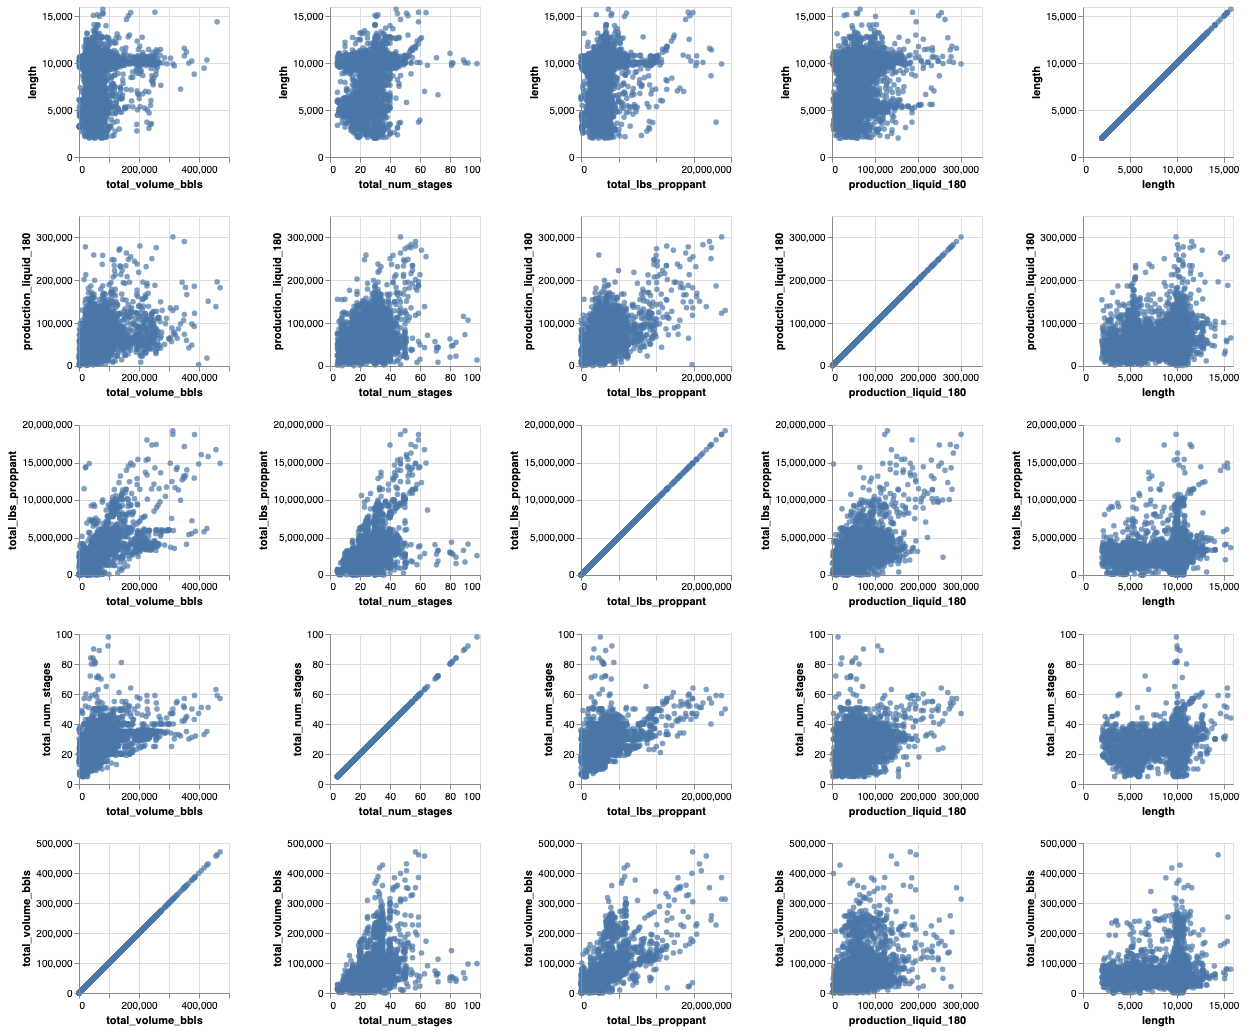

In [45]:
display(Markdown("### Comparing Total Measurements (After scrubbing outliers)"))
alt.Chart(clean_df[total_cols]).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    row=total_cols,
    column=total_cols[::-1]
)

### Comparing Normalized Measurements (After scrubbing outliers)

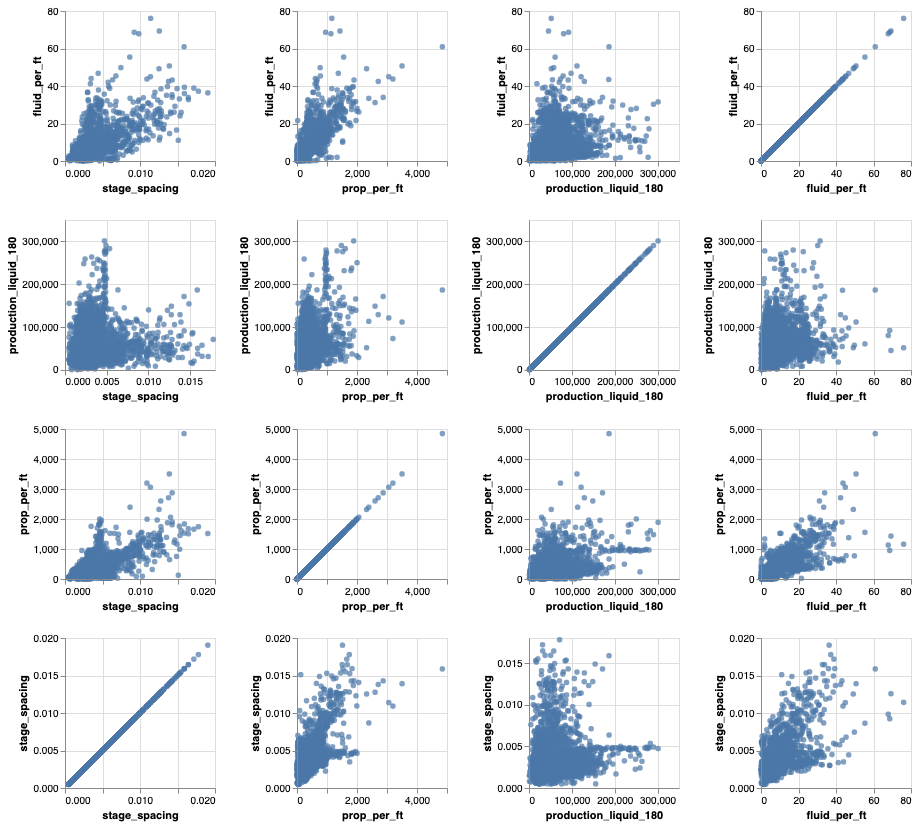

In [46]:
display(Markdown("### Comparing Normalized Measurements (After scrubbing outliers)"))
alt.Chart(clean_df).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
#     color='Origin:N'
).properties(
    width=150,
    height=150
).repeat(
    row=normd_cols,
    column=normd_cols[::-1]
)

### Comparing Depth Measurements

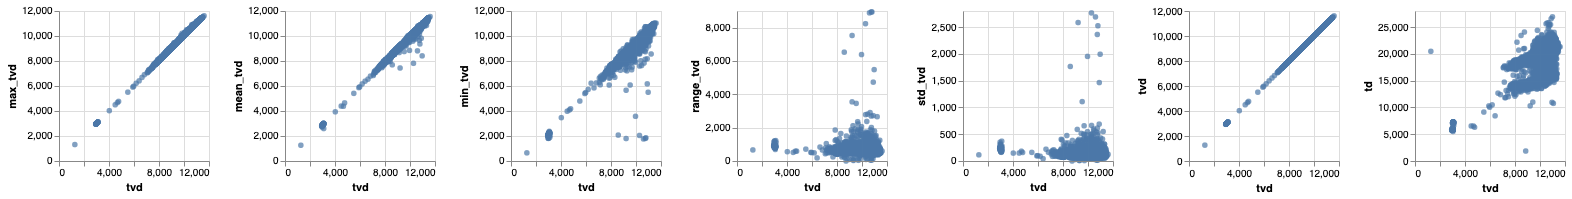

In [47]:
display(Markdown("### Comparing Depth Measurements"))
alt.Chart(inspect_df[tvd_cols]).mark_circle().encode(
    alt.X("tvd", type='quantitative'),
    alt.Y(alt.repeat("column"), type='quantitative'),
).properties(
    width=150,
    height=150
).repeat(
    column=tvd_cols,
)

### Correlation Matrix Heatmap, with Hierarchical Clustering

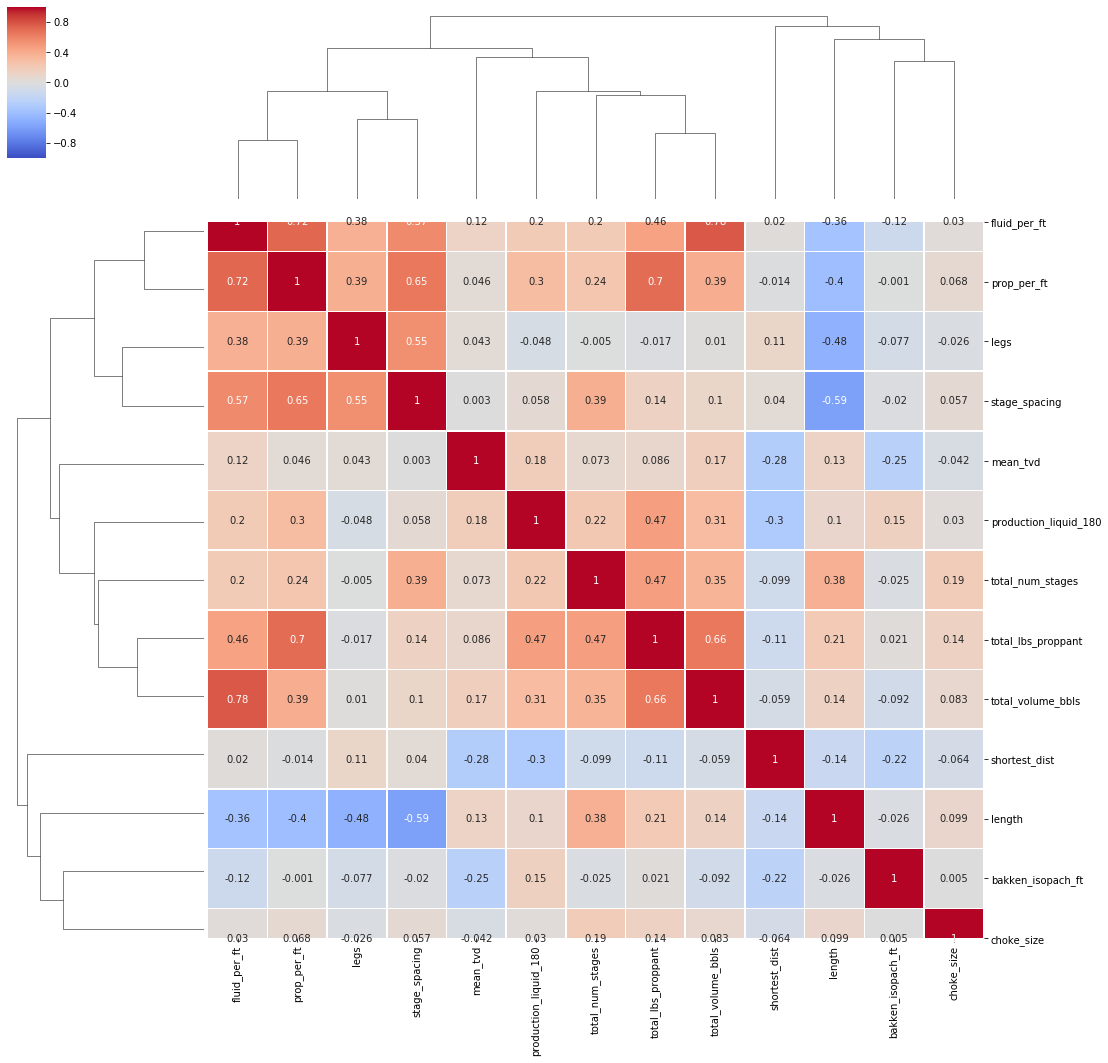

In [48]:
corr_df = clean_df.filter(foi).corr().round(3)

display(Markdown("### Correlation Matrix Heatmap, with Hierarchical Clustering"))
sns.clustermap(data=corr_df, 
                    cmap="coolwarm", 
                    linewidths=.5, 
                    vmin=-1, vmax=1, 
                    annot=True,
                   square=True
                )
fig = plt.gcf()  # or by other means, like plt.subplots
figsize = fig.get_size_inches()
fig.set_size_inches(figsize * 1.75)  # scale current size by 1.5

<a name="paragraph5"></a>
# Maps

In [49]:
map_df = (inspect_df.copy()
                      .filter(["surface_lng", "surface_lat", "mean_tvd", target_col, "stimulated_formation", "township", "countyname"])
                      .assign(township = lambda x: x["township"].dropna().apply(lambda x: int(x.split(" ")[0])))
                      .join(cat_df, lsuffix="_orig")
         )

### Where are highest producing wells?

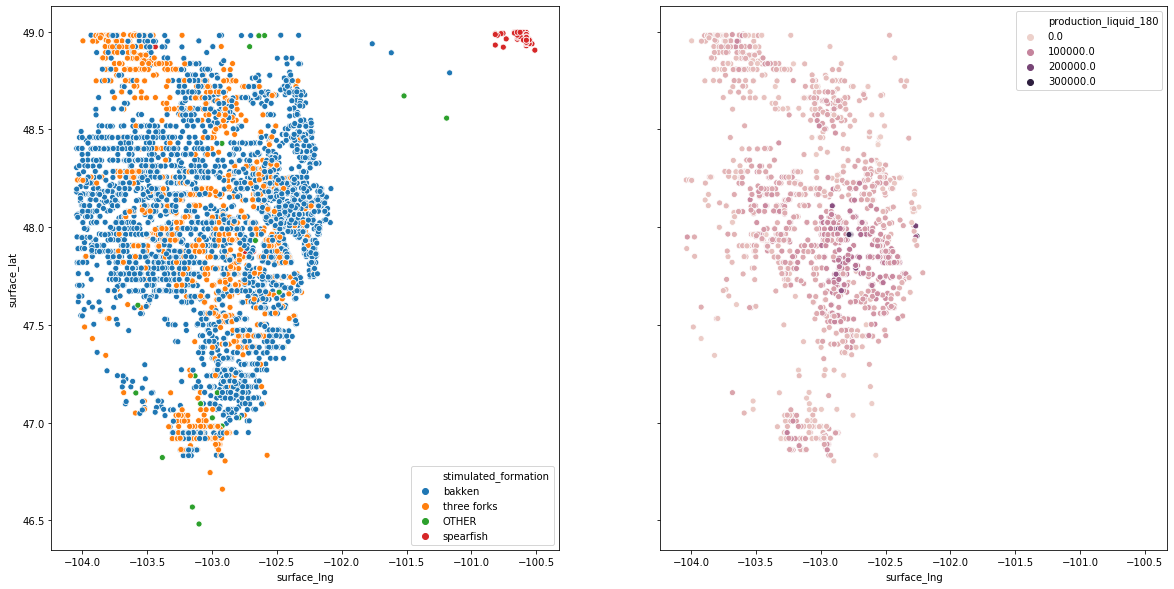

In [50]:
display(Markdown("### Where are highest producing wells?"))
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="stimulated_formation", ax=ax[0])
sns.scatterplot(data=map_df.query("stimulated_formation == 'three forks'"), x="surface_lng", y="surface_lat", hue=target_col, ax=ax[1])
plt.show()

### Political Geography: County and Township

township is basically just degrees latitude


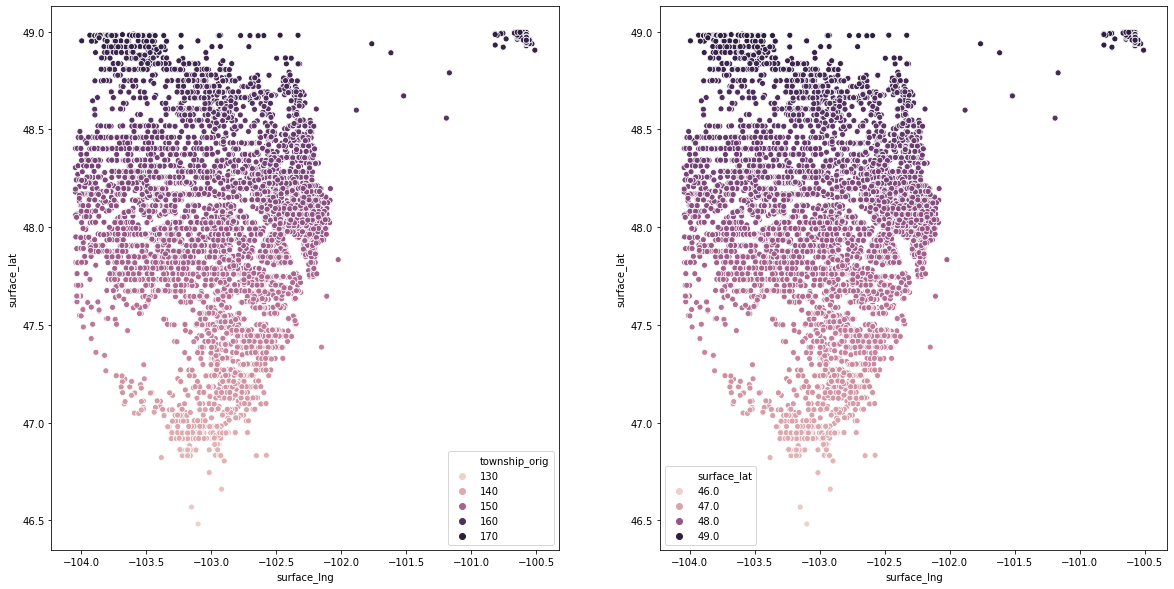

In [66]:
print("township is basically just degrees latitude")
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="township_orig", ax=ax[0])
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="surface_lat", ax=ax[1])

plt.show()

County is also just an administrative division, not a meaningful proxy for underlying geology.


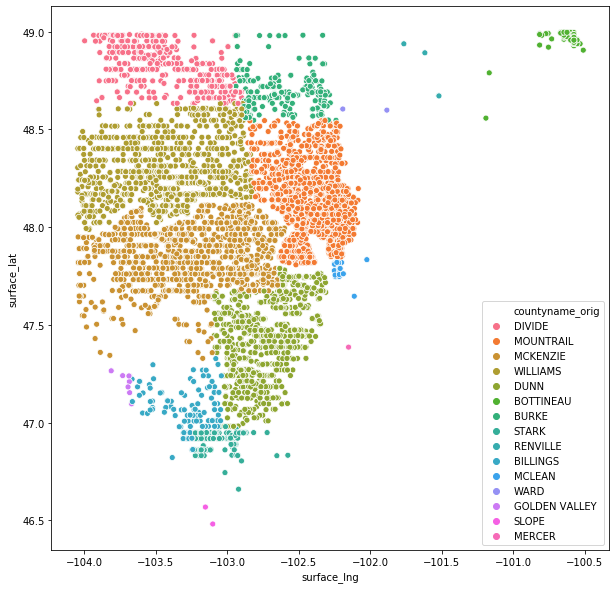

In [67]:
print("County is also just an administrative division, not a meaningful proxy for underlying geology.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="countyname_orig")
plt.show()

### Target Formation and TVD

There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.


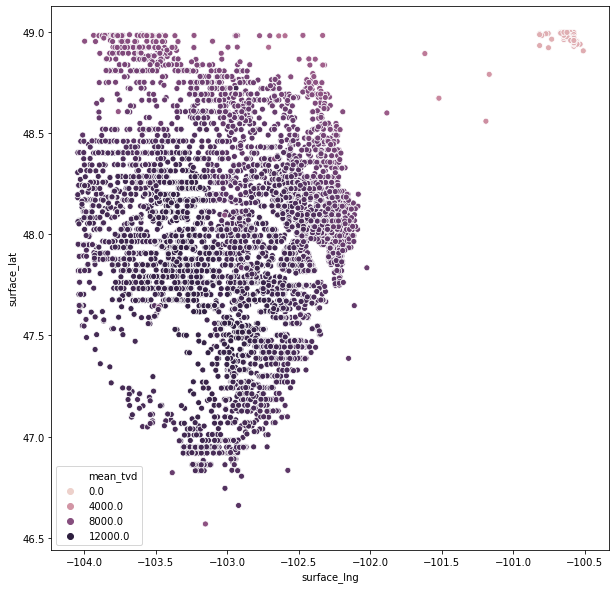

In [68]:
print("There is a group of wells in the NE corner are all much shallower. On the edge of the bowl.")
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=map_df, x="surface_lng", y="surface_lat", hue="mean_tvd")
plt.show()

Value Counts of Target Formation

bakken         4951
three forks    2016
NaN            1013
spearfish       104
OTHER            31
Name: stimulated_formation, dtype: int64

### Well Map, Colored and Faceted by Target Formation

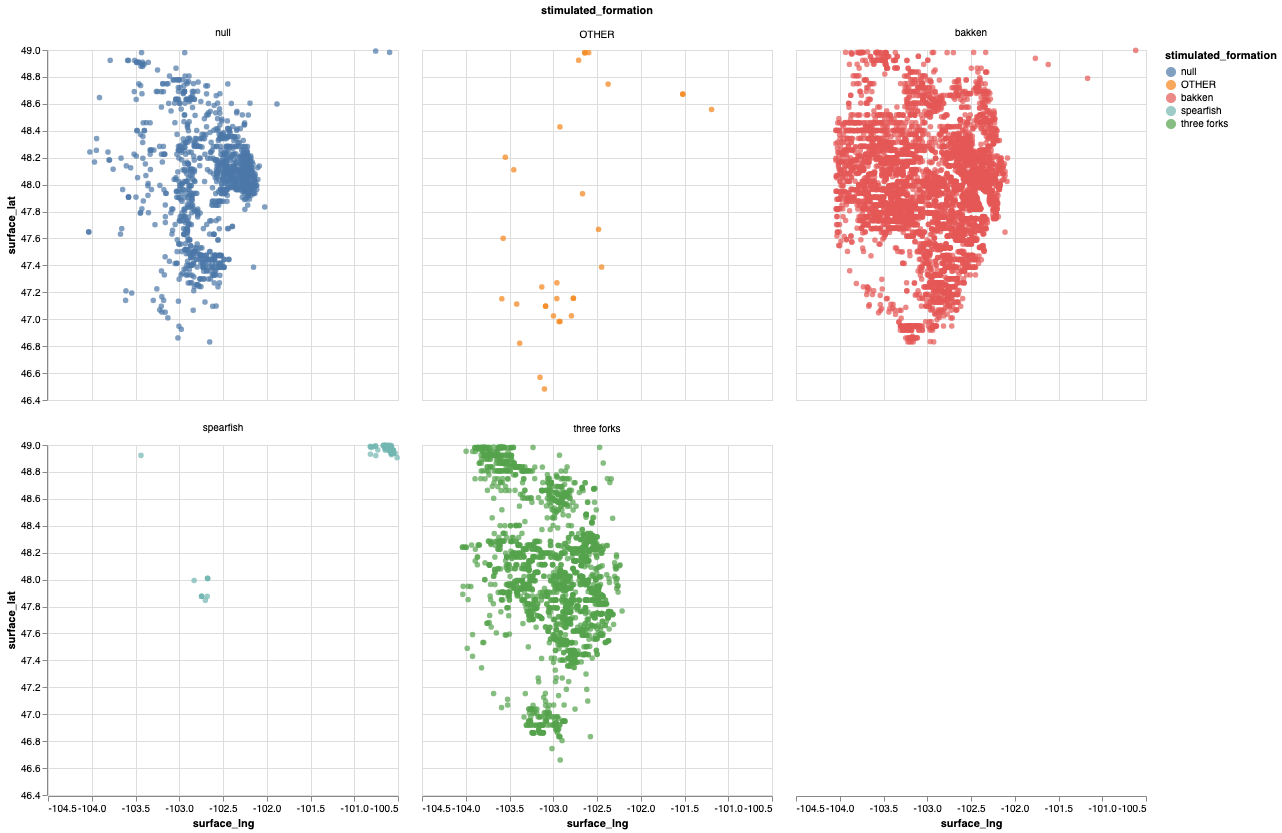

In [69]:
display(Markdown("Value Counts of Target Formation"),
        map_df.stimulated_formation.value_counts(dropna=False),
Markdown("### Well Map, Colored and Faceted by Target Formation"))
alt.Chart(map_df).mark_circle().encode(
    alt.X('surface_lng:Q',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('surface_lat:Q',
        scale=alt.Scale(zero=False)
    ),
    color='stimulated_formation:N',
#     column='stimulated_formation:N'
).properties(
    width=350,
    height=350
).facet(
    facet='stimulated_formation:N',
    columns=3
)

In [70]:
print("All of those wells in the NE corner have no production data.")
inspect_df.query("surface_lng > -101.5").filter(regex="production").notnull().sum()

All of those wells in the NE corner have no production data.


production_liquid_120     0
production_liquid_150     0
production_liquid_180     0
production_liquid_1825    0
production_liquid_270     0
production_liquid_30      0
production_liquid_365     0
production_liquid_60      0
production_liquid_730     0
production_liquid_90      0
dtype: int64

In [71]:
print("Spearfish wells NOT in the NE corner DO HAVE production data.")
inspect_df.query("surface_lng < -101.5 & stimulated_formation == 'spearfish'").filter(regex="production").notnull().sum()

Spearfish wells NOT in the NE corner DO HAVE production data.


production_liquid_120     10
production_liquid_150     10
production_liquid_180     10
production_liquid_1825     0
production_liquid_270      6
production_liquid_30      10
production_liquid_365      5
production_liquid_60      10
production_liquid_730      1
production_liquid_90      10
dtype: int64

In [72]:
total_formation_vc = (inspect_df.copy()
                      .filter(["stimulated_formation"])
                      .squeeze()
                      .value_counts(dropna=False)
                      .sort_index()
                      .to_frame()
                      .reset_index()
                      .rename(columns={"index": "stimulated_formation", "stimulated_formation": "total_count"})
                     )

missing_target_formation_vc = (inspect_df.copy()
                               .query(f"{target_col} != {target_col}")
                               .filter(["stimulated_formation"])
                               .squeeze()
                               .value_counts(dropna=False)
                               .sort_index()
                              .reset_index()
                              .rename(columns={"index": "stimulated_formation", "stimulated_formation": "missing_target_count"})
                               )


explore_vc = total_formation_vc.merge(missing_target_formation_vc, on="stimulated_formation")



Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?


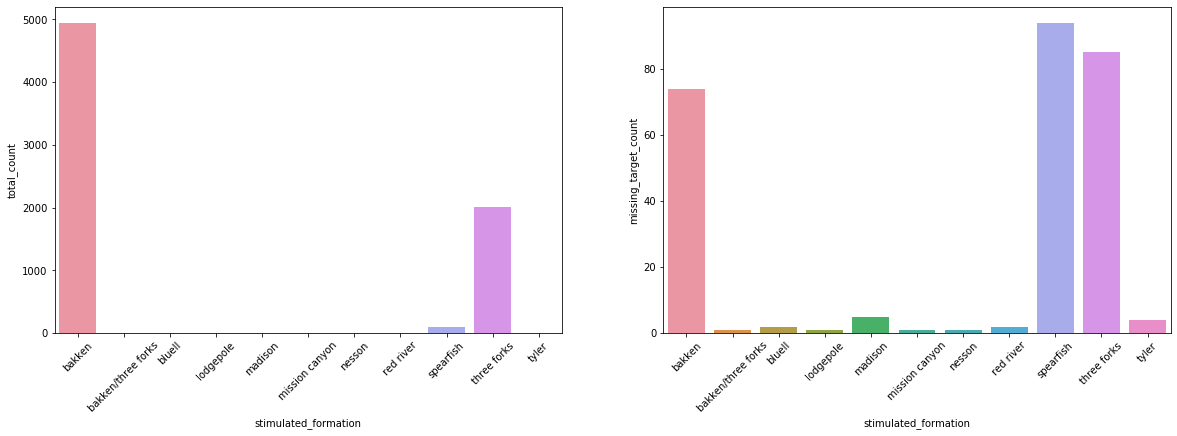

In [73]:
print("Spearfish wells account for a disproportionate number of missing values. Are they too young (recently drilled)?")
fig, ax  = plt.subplots(1,2, figsize=(20,6))
sns.barplot(data=explore_vc, x="stimulated_formation", y="total_count", ax=ax[0])
sns.barplot(data=explore_vc, x="stimulated_formation", y="missing_target_count", ax=ax[1])
for item in ax[0].get_xticklabels() + ax[1].get_xticklabels():
        item.set_rotation(45)

### 90% of Spearfish wells are missing, including all of those in the NE corner

In [74]:
spearfish_df = inspect_df.query("stimulated_formation == 'spearfish'")

### These are not just young wells. Still 90% missing at day 30.

In [75]:
display((spearfish_df.filter(regex="production_liquid").isnull().sum() / spearfish_df.shape[0] * 100).to_frame())

0
production_liquid_120   90.38
production_liquid_150   90.38
production_liquid_180   90.38
production_liquid_1825 100.00
production_liquid_270   94.23
production_liquid_30    90.38
production_liquid_365   95.19
production_liquid_60    90.38
production_liquid_730   99.04
production_liquid_90    90.38

### Visualize distance to nearest neighbor

In [76]:
print("Seems like it worked")
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="shortest_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("shortest_dist > .1"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

Seems like it worked


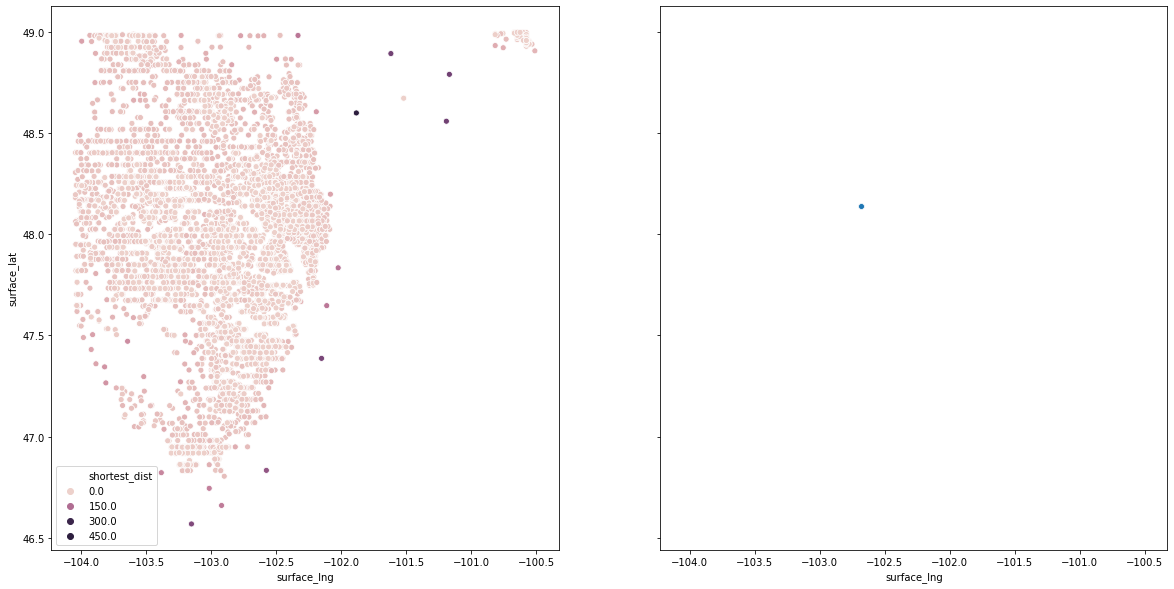

In [77]:
# The most densely spaced wells
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
sns.scatterplot(data=inspect_df, x="surface_lng", y="surface_lat", hue="shortest_dist", ax=ax[0])
sns.scatterplot(data=inspect_df.query("shortest_dist < .002"), x="surface_lng", y="surface_lat", ax=ax[1])
plt.show()

<a name="paragraph6"></a>
# Temporal Analysis

## Frac Year

In [78]:
date_df = (inspect_df.copy()
                      .assign(spud_year=lambda x: x["spud_date"].dropna().apply(lambda x: int(x.split("-")[0])))
          )

In [79]:
sns.stripplot(date_df.spud_year)

In [80]:
date_df.head()

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33023010680000              90.00   48.73 -103.85      28/64     DIVIDE   
33061019000000             110.00   48.14 -102.33      64/64  MOUNTRAIL   
33053051430000              80.00   47.67 -102.87      18/64   MCKENZIE   
33053045070000              80.00   47.70 -102.71      22/64   MCKENZIE   
33053047660000              90.00   47.72 -103.25      39/64   MCKENZIE   

                                   currentoperator  \
api                                                  
33023010680000                    HUNT OIL COMPANY   
33061019000000     WHITING OIL AND GAS CORPORATION   
33053051430000         NEWFIELD PRODUCTION COMPANY   
33053045070000  ENERPLUS RESOURCES USA CORPORATION   
33053047660000     WHITING OIL AND GAS CORPORATION   

                                 currentwellname data_group  dfelev  \
api                                                                   
33023010680000    WRITING ROCK  161-101-30-31H-1       TEST     nan   
33061019000000                 JORGENSEN  11-27H       TEST     nan   
33053051430000  MOBERG FEDERAL  149-95-29-32-11H       TEST     nan   
33053045070000            CIRRUS  149-94-33D-28H       TEST     nan   
33053047660000               SMOKEY  3-17-20-14H       TEST     nan   

                   fieldname  ...  wellstatus welltype   length  prop_per_ft  \
api                           ...                                              
33023010680000  WRITING ROCK  ...           A       OG  6164.12       438.36   
33061019000000        SANISH  ...           A       OG  9150.57       204.01   
33053051430000      BEAR DEN  ...           A       OG  9926.80       166.36   
33053045070000    EAGLE NEST  ...           A       OG 10054.43       648.03   
33053047660000      PEMBROKE  ...           A       OG  2785.10      1526.69   

               fluid_per_ft stage_spacing  range_tvd  frac_year  \
api                                                               
33023010680000         9.44          0.00     587.62    2013.00   
33061019000000         2.97          0.00     613.44    2011.00   
33053051430000         1.62          0.00     556.98    2013.00   
33053045070000         4.69          0.00     630.82    2012.00   
33053047660000        34.53          0.01     547.30    2013.00   

                shortest_dist  spud_year  
api                                       
33023010680000          29.39    2013.00  
33061019000000           3.97    2011.00  
33053051430000           1.64    2013.00  
33053045070000           7.88    2012.00  
33053047660000           9.87    2013.00  

[5 rows x 61 columns]

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="length", x="spud_year")

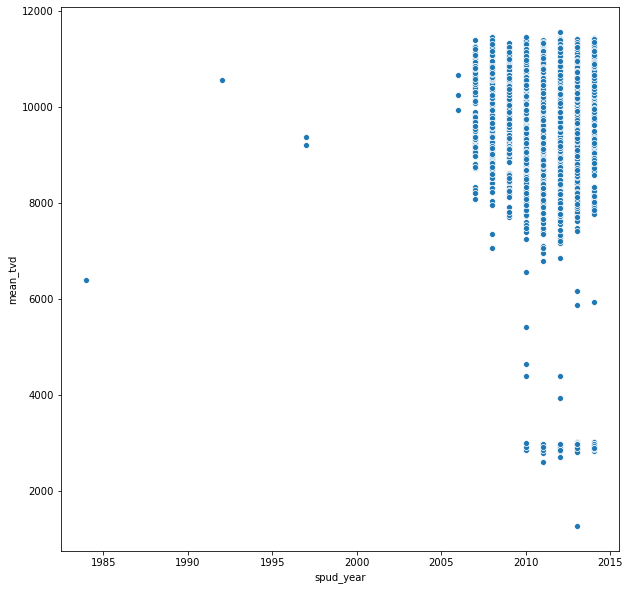

In [82]:
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=date_df, y="mean_tvd", x="spud_year")

In [83]:
date_df.query("spud_year < 2006")

bakken_isopach_ft  bh_lat  bh_lng choke_size countyname  \
api                                                                       
33105014330000              70.00   48.20 -103.55        /64   WILLIAMS   
33053024160000              30.00   47.46 -103.64        /64   MCKENZIE   
33013011070000              70.00   48.74 -102.37     164/64      BURKE   
33007013860000              20.00   46.82 -103.38        NaN   BILLINGS   

                                       currentoperator       currentwellname  \
api                                                                            
33105014330000                            ZAVANNA, LLC        JEFFREY  33-33   
33053024160000                        EMERALD OIL, INC      FEDERAL  21-14HR   
33013011070000  PETRO HARVESTER OPERATING COMPANY, LLC          OPSETH  29-1   
33007013860000                    DENBURY ONSHORE, LLC  SOUTH FRYBURG  40-26   

               data_group  dfelev       fieldname  ...  wellstatus welltype  \
api                                                ...                        
33105014330000       TEST     nan       WILLISTON  ...          AB       OG   
33053024160000      TRAIN     nan  FLAT TOP BUTTE  ...           A       OG   
33013011070000      TRAIN     nan    SOUTH COTEAU  ...           A       OG   
33007013860000      TRAIN     nan         FRYBURG  ...           A       OG   

                length  prop_per_ft fluid_per_ft stage_spacing  range_tvd  \
api                                                                         
33105014330000 1611.36          nan         0.01          0.00     418.68   
33053024160000 2563.09       403.54        11.26          0.01     508.18   
33013011070000 1085.17          nan         0.18          0.00     186.11   
33007013860000 1110.99        47.67         2.78          0.00     122.54   

                frac_year  shortest_dist  spud_year  
api                                                  
33105014330000    1997.00           6.01    1997.00  
33053024160000    1992.00          99.04    1992.00  
33013011070000    1984.00          11.67    1984.00  
33007013860000    1997.00         109.82    1997.00  

[4 rows x 61 columns]

In [84]:
date_df.query("wellbore in ['HORIZONTAL RE-ENTRY', 'DIRECTIONAL']").filter(["wellbore", "spud_date", "length", "stimulated_formation"]).sort_values("wellbore")

wellbore   spud_date  length stimulated_formation
api                                                                         
33061011940000          DIRECTIONAL  2010-02-04     nan          three forks
33007015830000          DIRECTIONAL  2010-04-10     nan              madison
33089005680000          DIRECTIONAL  2007-04-07     nan                  NaN
33025013510000          DIRECTIONAL  2011-05-28     nan            red river
33053043750000          DIRECTIONAL  2012-09-28     nan            red river
33053024160000  HORIZONTAL RE-ENTRY  1992-11-27 2563.09               bakken
33013011070000  HORIZONTAL RE-ENTRY  1984-10-30 1085.17               nesson
33023005530000  HORIZONTAL RE-ENTRY  2009-08-06 5734.45                  NaN
33101004750000  HORIZONTAL RE-ENTRY  2008-06-23 7603.19                  NaN
33007013860000  HORIZONTAL RE-ENTRY  1997-11-02 1110.99                tyler
33053027480000  HORIZONTAL RE-ENTRY  2008-01-31 2945.31                  NaN

In [85]:
date_df.query("wellbore == 'HORIZONTAL RE-ENTRY'").filter(["wellbore", "spud_date", "length", "stimulated_formation", target_col])

wellbore   spud_date  length stimulated_formation  \
api                                                                            
33053024160000  HORIZONTAL RE-ENTRY  1992-11-27 2563.09               bakken   
33013011070000  HORIZONTAL RE-ENTRY  1984-10-30 1085.17               nesson   
33023005530000  HORIZONTAL RE-ENTRY  2009-08-06 5734.45                  NaN   
33101004750000  HORIZONTAL RE-ENTRY  2008-06-23 7603.19                  NaN   
33007013860000  HORIZONTAL RE-ENTRY  1997-11-02 1110.99                tyler   
33053027480000  HORIZONTAL RE-ENTRY  2008-01-31 2945.31                  NaN   

                production_liquid_180  
api                                    
33053024160000               40223.00  
33013011070000                    nan  
33023005530000               18946.00  
33101004750000                    nan  
33007013860000                    nan  
33053027480000               21060.00

In [86]:
date_df.wellbore.value_counts()

HORIZONTAL             8104
HORIZONTAL RE-ENTRY       6
DIRECTIONAL               5
Name: wellbore, dtype: int64

## Production Data over time, for each well

In [87]:
inspect_df.query("production_liquid_90 > 0").shape

(7954, 60)

In [88]:
prod_df = (inspect_df.copy()
                   .filter(regex="production_liquid")
                   .query("production_liquid_30 > 0")
                   .rename(columns=lambda x: int(x.split("_")[-1]))
                   .drop([1825], axis=1)
                   .reset_index()
                   .melt(id_vars="api", value_name="cum_prod", var_name="ip_day")
                   .sort_values(["api", "ip_day"])
                   .reset_index(drop=True)
                   .assign(
                           ip_day=lambda x: x["ip_day"].astype(int),
                           cum_prod=lambda x: x["cum_prod"].astype(float),
                           day_diff=lambda x: x.groupby(["api"])["ip_day"].transform(pd.Series.diff),
                           prod_diff=lambda x: x.groupby(["api"])["cum_prod"].transform(pd.Series.diff),
                           prod_rate = lambda x: (x["prod_diff"] / x["day_diff"]).round(2)
                          )     
          )

In [89]:
prod_df.head()

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
0  33007015740000      30   4829.00       nan        nan        nan
1  33007015740000      60   9223.00     30.00    4394.00     146.47
2  33007015740000      90  12745.00     30.00    3522.00     117.40
3  33007015740000     120  15051.00     30.00    2306.00      76.87
4  33007015740000     150  15975.00     30.00     924.00      30.80

In [90]:
well_ids = inspect_df.index.to_list()
well_ids[:10]

['33023010680000',
 '33061019000000',
 '33053051430000',
 '33053045070000',
 '33053047660000',
 '33053049720000',
 '33061020550000',
 '33061025000000',
 '33053049810000',
 '33105023020000']

In [91]:
ip_days = sorted(prod_df.ip_day.unique())

In [92]:
ip_days

[30, 60, 90, 120, 150, 180, 270, 365, 730]

In [93]:
def plot_well_curve(prod_df, well_id):
    sub_df = prod_df.query("api == @well_id")
    display(Markdown(f"## {well_id}"))
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(sub_df["ip_day"], sub_df["cum_prod"], marker="o")
    ax[1].plot(sub_df["ip_day"], sub_df["prod_rate"],marker="o")
    plt.show()
    display(sub_df)

### Here is a normal-looking production curve

## 33053045070000

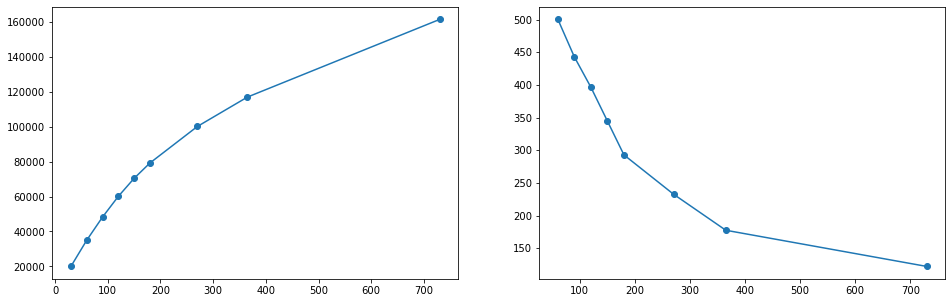

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
31329  33053045070000      30  19949.00       nan        nan        nan
31330  33053045070000      60  34958.00     30.00   15009.00     500.30
31331  33053045070000      90  48239.00     30.00   13281.00     442.70
31332  33053045070000     120  60128.00     30.00   11889.00     396.30
31333  33053045070000     150  70463.00     30.00   10335.00     344.50
31334  33053045070000     180  79246.00     30.00    8783.00     292.77
31335  33053045070000     270 100184.00     90.00   20938.00     232.64
31336  33053045070000     365 117038.00     95.00   16854.00     177.41
31337  33053045070000     730 161572.00    365.00   44534.00     122.01

In [94]:
well_oi = well_ids[3]
plot_well_curve(prod_df, well_oi)

### Here is an abnormal-looking production curve:
This is something that could be cleaned up to improve model accuracy.

In [95]:
well_oi = well_ids[1001]
plot_well_curve(prod_df, well_oi)

## 33053044080000

api  ip_day  cum_prod  day_diff  prod_diff  prod_rate
30726  33053044080000      30   3960.00       nan        nan        nan
30727  33053044080000      60  16727.00     30.00   12767.00     425.57
30728  33053044080000      90  38160.00     30.00   21433.00     714.43
30729  33053044080000     120  58218.00     30.00   20058.00     668.60
30730  33053044080000     150  79035.00     30.00   20817.00     693.90
30731  33053044080000     180  93811.00     30.00   14776.00     492.53
30732  33053044080000     270 106970.00     90.00   13159.00     146.21
30733  33053044080000     365 131117.00     95.00   24147.00     254.18
30734  33053044080000     730       nan    365.00        nan        nan

<a name="paragraph7"></a>
# Preliminary model fitting

In [96]:
target_col = "production_liquid_180"

In [97]:
def fill_median(df, cols=None):
    df = df.copy()
    
    if cols == None:
        cols = df.columns
    for col in cols:
        fill_value = df[col].median()
        df[col].fillna(value=fill_value, inplace=True)
        
    return df

In [98]:
model_features = summary_df.query("using == True").index.tolist()

model_features += coord_cols

In [99]:
model_features

['total_num_stages',
 'bakken_isopach_ft',
 'fluid_per_ft',
 'length',
 'mean_tvd',
 'min_tvd',
 'prop_per_ft',
 'range_tvd',
 'shortest_dist',
 'stage_spacing',
 'std_tvd',
 'td',
 'total_lbs_proppant',
 'total_volume_bbls',
 'tvd',
 'choke_size',
 'surface_lat',
 'surface_lng',
 'bh_lat',
 'bh_lng']

In [100]:
coord_cols

['surface_lat', 'surface_lng', 'bh_lat', 'bh_lng']

In [101]:
# model_features += coord_cols

In [102]:
model_features

['total_num_stages',
 'bakken_isopach_ft',
 'fluid_per_ft',
 'length',
 'mean_tvd',
 'min_tvd',
 'prop_per_ft',
 'range_tvd',
 'shortest_dist',
 'stage_spacing',
 'std_tvd',
 'td',
 'total_lbs_proppant',
 'total_volume_bbls',
 'tvd',
 'choke_size',
 'surface_lat',
 'surface_lng',
 'bh_lat',
 'bh_lng']

In [103]:
full_df = (inspect_df.copy()
               .dropna(subset=[target_col])
               .pipe(mwd.normalize_formation, "stimulated_formation", "producedpools")
               .assign(choke_size=lambda x: x["choke_size"].apply(lambda x: mwd.parse_choke_size(x)),
                       spud_year=lambda x: x["spud_date"].dropna().apply(lambda x: int(x.split("-")[0]))
                      )
               .filter(model_features + ["spud_year", target_col])
               .pipe(fill_median) 
          )

In [104]:
full_df.head()

total_num_stages  bakken_isopach_ft  fluid_per_ft   length  \
api                                                                          
33023010680000                25              90.00          9.44  6164.12   
33061019000000                26             110.00          2.97  9150.57   
33053051430000                32              80.00          1.62  9926.80   
33053045070000                23              80.00          4.69 10054.43   
33053047660000                33              90.00         34.53  2785.10   

                mean_tvd  min_tvd  prop_per_ft  range_tvd  shortest_dist  \
api                                                                        
33023010680000   8682.48  8169.17       438.36     587.62          29.39   
33061019000000   9827.68  9318.78       204.01     613.44           3.97   
33053051430000  10980.10 10475.13       166.36     556.98           1.64   
33053045070000  11024.49 10452.52       648.03     630.82           7.88   
33053047660000  11109.07 10656.34      1526.69     547.30           9.87   

                stage_spacing  ...  total_lbs_proppant  total_volume_bbls  \
api                            ...                                          
33023010680000           0.00  ...          2702100.00           58176.00   
33061019000000           0.00  ...          1866840.00           27187.00   
33053051430000           0.00  ...          1651440.00           16129.00   
33053045070000           0.00  ...          6515590.00           47161.00   
33053047660000           0.01  ...          4251992.00           96171.00   

                    tvd  choke_size  surface_lat  surface_lng  bh_lat  bh_lng  \
api                                                                             
33023010680000  8756.79        0.44        48.75      -103.85   48.73 -103.85   
33061019000000  9830.13        1.00        48.14      -102.37   48.14 -102.33   
33053051430000 11023.77        0.28        47.70      -102.87   47.67 -102.87   
33053045070000 11068.31        0.34        47.67      -102.71   47.70 -102.71   
33053047660000 11190.58        0.61        47.73      -103.25   47.72 -103.25   

                spud_year  production_liquid_180  
api                                               
33023010680000    2013.00               25694.00  
33061019000000    2011.00               45299.00  
33053051430000    2013.00               12653.00  
33053045070000    2012.00               79246.00  
33053047660000    2013.00               74794.00  

[5 rows x 22 columns]

In [105]:
test_df, train_df = train_test_split(full_df)
train_X, train_y = mft.X_y_split(train_df, target=target_col)
test_X, test_y = mft.X_y_split(test_df, target=target_col)

In [106]:
gbr = GradientBoostingRegressor(learning_rate=0.01,
                                n_estimators=500, 
                                subsample = .7, 
                                max_depth =7, 
                                min_samples_split= 3, 
                                random_state=1984)

In [107]:
gbr.fit(train_X, train_y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=1984, subsample=0.7, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### Error metrics

In [108]:
mse, mae, rmse, rrse = mft.eval_model(gbr, test_X, test_y, train_y)

y_hat = gbr.predict(test_X)

eval_df = (pd.concat([test_y.reset_index(), pd.Series(y_hat, name="pred").round(2)], axis=1)
           .set_index("api")
           .rename(columns={target_col: "actual"})
           .assign(resid=lambda x: x["pred"] - x["actual"])
           .assign(perc_resid=lambda x: x["resid"] / x["actual"] * 100)
           .assign(abs_resid=lambda x: x["resid"].abs())
           .assign(abs_perc_resid=lambda x: x["abs_resid"] / x["actual"] * 100)
          )

mape = eval_df.abs_perc_resid.mean()

mape_adj = eval_df.abs_resid.mean() / eval_df.actual.mean() * 100

In [109]:
error_dict = {"mae ": mae, "rmse": rmse, "rrse": rrse, "mape": mape, "adj_mape": mape_adj}

In [110]:
for name, val in error_dict.items():
    print(name, val.round())

mae  16044.0
rmse 21850.0
rrse 66.0
mape 42.0
adj_mape 27.0


In [111]:
for name, val in error_dict.items():
    print(name, val.round())

mae  16044.0
rmse 21850.0
rrse 66.0
mape 42.0
adj_mape 27.0


In [112]:
plt.subplots(figsize=(10, 10))
plt.scatter(data=eval_df, x="actual", y="pred")
plt.plot([0, 300000], [0, 300000], c="k", linewidth=3)

### The model is clearly biased: it's overpredicting small values and underpredicting large values

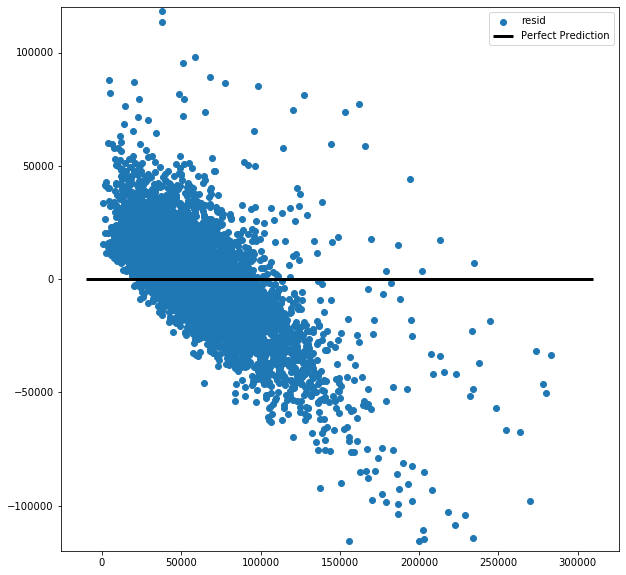

In [113]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(data=eval_df, x="actual", y="resid")
ax.set_ylim(-120000, 120000)
ax.hlines(y=0, xmin=-10000, xmax=310000, label="Perfect Prediction", linewidth=3)
plt.legend()

In [114]:
feat_imp_df = mft.get_rig_df(gbr, train_X.columns.values)

In [115]:
feat_imp_df

importance
feature                       
total_lbs_proppant        0.20
surface_lat               0.12
bakken_isopach_ft         0.07
shortest_dist             0.07
surface_lng               0.06
total_volume_bbls         0.05
bh_lat                    0.05
bh_lng                    0.04
stage_spacing             0.04
total_num_stages          0.04
td                        0.03
range_tvd                 0.03
min_tvd                   0.03
tvd                       0.03
length                    0.03
std_tvd                   0.02
mean_tvd                  0.02
prop_per_ft               0.02
fluid_per_ft              0.02
spud_year                 0.01
choke_size                0.01

In [116]:
# This all makes sense
feat_imp_df.plot.barh(figsize=(10, 6), )

### TODO:
- [X] Table of Contents, 
- [ ] Flesh out narrative
- [ ] Drop rows with multiple missing values, esply lat/lon
- [ ] Import formation tops, recaluclate target formation
- [ ] Detect anomalies and impute production for young wells
